In [18]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
import pyneb as pn


In [36]:
def spec(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y):
    y = np.sum(np.sum(wo_cube[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2],axis=1),axis=1)
    y_err = np.sqrt(np.sum(np.sum(((wo_err[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]))**2,axis=1),axis=1))
    return y,y_err

def SII_fit(wo_wave,data,error,z,p_init_SII):
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    popt_full_fit,pcov_full_fit = leastsq(test_gauss_SII,x0=p_init_SII,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(test_gauss_SII,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
        parameters_err = np.std(parameters_MC,1)  
    (amp_SII6716_error,amp_SII6731_error,vel_SII6731_error,vel_sigma_SII6731_error,amp_SII6716_br_error,amp_SII6731_br_error,vel_SII6731_br_error,vel_sigma_SII6731_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

def coupled_fit(wo_wave,data,error,z,p_init_complex):
    k = 1+z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    popt_full_fit,pcov_full_fit = leastsq(complex_gauss_coupled,x0=p_init_complex,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(complex_gauss_coupled,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    return popt_full_fit,parameters_err 

def decoupled_fit(wo_wave,data,error,z,p_init_fit):
    k = 1+z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    popt_full_fit,pcov_full_fit = leastsq(complex_gauss_decoupled,x0=p_init_fit,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(complex_gauss_decoupled,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    return popt_full_fit,parameters_err 

In [38]:
def amp_complex_table(obj,amp_par,amp_par_err):
    column_names={'aamp_SII6716_nr_ind':0,'amp_SII6731_nr_ind':1,'amp_SII6716_br_ind':2,'amp_SII6731_br_ind':3,'amp_Ha_nr_fix':4,'amp_NII6583_nr_fix':5,'amp_SII6716_nr_fix':6,'amp_SII6731_nr_fix':7,'amp_Ha_br_fix':8,'amp_NII6583_br_fix':9,'amp_SII6716_br_fix':10,'amp_SII6731_br_fix':11,'amp_Ha_nr_nonfix':12,'amp_NII6583_nr_nonfix':13,'amp_SII6716_nr_nonfix':14,
                 'amp_SII6731_nr_nonfix':15,'amp_Ha_br_nonfix':16,'amp_NII6583_br_nonfix':17,'amp_SII6716_br_nonfix':18,'amp_SII6731_br_nonfix':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[kin_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[kin_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_amp_par_compare.fits'%(obj),overwrite=True)

def Ne_wo_err_tab(obj,Ne_array):
    column_names={'Ne_nr_ind':0,'Ne_wing_ind':1,'Ne_core_fix':2,'Ne_wing_fix':3,'Ne_core_nonfix':4,'Ne_wing_nonfix':5}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt_full_fit[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_Ne_tab.fits'%(obj),overwrite=True)

def kin_par_table(obj,kin_par,kin_par_err):
    column_names={'vel_SII_nr_ind':0,'vel_sigma_SII_nr_ind':1,'vel_SII_br_ind':2,'vel_sigma_SII_br_ind':3,'vel_SII_nr_fix':4,'vel_sigma_SII_nr_fix':5,'vel_SII_br_fix':6,
              'vel_sigma_SII_br_fix':7,'vel_SII_nr_nonfix':8,'vel_sigma_SII_nr_nonfix':9,'vel_SII_br_nonfix':10,'vel_sigma_SII_br_nonfix':11}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[kin_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[kin_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_kin_par_compare.fits'%(obj),overwrite=True)

In [39]:
def algorithm_script(obj,z,p_init_SII,p_init_complex,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    print '%s'%(obj)
    try:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.binned.fits'%(prefix_path_cube,obj,obj))
    except IOError:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.unbinned.fits'%(prefix_path_cube,obj,obj))   
    (cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    (QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/MUSE/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    difference = difference_in_wavelength_dimension(orig_cube,cont_cube)
    (wo_cube,wo_err,wo_wave,wo_header) = create_wo_absorption_cube(obj,orig_cube,orig_err,orig_header,cont_cube,cont_wave,difference)
    
    #####################Get the integrated spectrum####################################################
    [brightest_pixel_x,brightest_pixel_y] = central_pixel(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(brightest_pixel_x),int(brightest_pixel_y)]
    (data,error) = spec(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y)
    k = 1+z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    plt.plot(wo_wave[select],data[select],'k-',label='data')
    plt.show()
    
    ################# Perform the SII fit alone##############################################################
    (popt_SII_fit,parameters_err_SII) = SII_fit(wo_wave,data,error,z,p_init_SII)
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_SII,c_SII) = popt_SII_fit
    (amp_SII6716_fit_err,amp_SII6731_fit_err,vel_SII6731_fit_err,vel_sigma_SII6731_fit_err,amp_SII6716_br_fit_err,amp_SII6731_br_fit_err,vel_SII6731_br_fit_err,vel_sigma_SII6731_br_fit_err,m_SII_err,c_SII_err) = parameters_err_SII

    ################# Check the lectron density for the independent fit####################
    (ratio_core_ind,ratio_wing_ind) = flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit) 
    print (ratio_core_ind,ratio_wing_ind)  
    (Ne_core_ind, Ne_wing_ind) = electron_density(ratio_core_ind,ratio_wing_ind)    
    #(Ne_core_err_ind,Ne_wing_err_ind,low_ind,high_ind) = electron_density_err(amp_SII6716_fit,amp_SII6716_fit_err,amp_SII6731_fit,amp_SII6731_fit_err,amp_SII6716_br_fit,amp_SII6716_br_fit_err,amp_SII6731_br_fit,amp_SII6731_br_fit_err)
    print 'electron_density_core_indep_fit is',Ne_core_ind
    print 'electron_density_wing_indep_fit',Ne_wing_ind
    
    #################### perform the fit with coupling H-alpha + [NII] kinematics with [SII]##########################
    (popt_coupled_fit,parameters_err_coupled) = coupled_fit(wo_wave,data,error,z,p_init_complex)
    print popt_coupled_fit
    plot_coupled_kin(obj,wo_wave,data,error,z,popt_coupled_fit)
    (amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,vel_core_fit,vel_sigma_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit,vel_wing_fit,vel_sigma_wing_fit,amp_Ha_blr1_fit,vel_blr1_fit,vel_sigma_blr1_fit,amp_Ha_blr2_fit,vel_blr2_fit,vel_sigma_blr2_fit,amp_Ha_blr3_fit,vel_blr3_fit,vel_sigma_blr3_fit,m_fit,c_fit)= popt_coupled_fit
    (amp_Ha_core_fit_err,amp_NII6583_core_fit_err,amp_SII6716_core_fit_err,amp_SII6731_core_fit_err,vel_core_fit_err,vel_sigma_core_fit_err,amp_Ha_wing_fit_err,amp_NII6583_wing_fit_err,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err,amp_Ha_blr1_fit_err,vel_blr1_fit_err,vel_sigma_blr1_fit_err,amp_Ha_blr2_fit_err,vel_blr2_fit_err,vel_sigma_blr2_fit_err,amp_Ha_blr3_fit_err,vel_blr3_fit_err,vel_sigma_blr3_fit_err,m_fit_err,c_fit_err)= parameters_err_coupled
   
    ################# Check the lectron density for the coupled fit####################
    (ratio_core_coupled,ratio_wing_coupled) = flux_ratio(amp_SII6716_core_fit,amp_SII6731_core_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit) 
    print (ratio_core_coupled,ratio_wing_coupled)  
    (Ne_core_coupled, Ne_wing_coupled) = electron_density(ratio_core_coupled,ratio_wing_coupled)    
    #(Ne_core_err_coup,Ne_wing_err_coup,low_coup,high_coup) = electron_density_err(amp_SII6716_core_fit,amp_SII6716_core_fit_err,amp_SII6731_core_fit,amp_SII6731_core_fit_err,amp_SII6716_wing_fit,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit,amp_SII6731_wing_fit_err)
    print 'electron_density_core_coupled is',Ne_core_coupled,Ne_core_err_coup
    print 'electron_density_wing_coupled is',Ne_wing_coupled,Ne_wing_err_coup,low_coup,high_coup
        
    ############### Use the previous fit parameters(some) to fit the H-alpha + [NII] ++ decoupled [SII]#################
    p_init_fit = (amp_Ha_core_fit,amp_NII6583_core_fit,vel_core_fit,vel_sigma_core_fit,amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,vel_wing_fit,vel_sigma_wing_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,amp_Ha_blr1_fit,vel_blr1_fit,vel_sigma_blr1_fit,amp_Ha_blr2_fit,vel_blr2_fit,vel_sigma_blr2_fit,amp_Ha_blr3_fit,vel_blr3_fit,vel_sigma_blr3_fit,-2.19991913e+00,2.46898420e+01)
    #print 'fit parameters guess is', p_init_fit
    (popt_decoupled_fit,parameters_err_decoupled) = decoupled_fit(wo_wave,data,error,z,p_init_fit)
    print popt_decoupled_fit
    plot_decoupled_kin(obj,wo_wave,data,error,z,popt_decoupled_fit)
    (amp_Ha_core,amp_NII6583_core,vel_Ha_core,vel_sigma_Ha_core,amp_SII6716_core,amp_SII6731_core,vel_SII6731_core,vel_sigma_SII6731_core,amp_Ha_wing,amp_NII6583_wing,vel_Ha_wing,vel_sigma_Ha_wing,amp_SII6716_wing,amp_SII6731_wing,vel_SII6731_wing,vel_sigma_SII6731_wing,amp_Ha_blr1,vel_blr1,vel_sigma_blr1,amp_Ha_blr2,vel_blr2,vel_sigma_blr2,amp_Ha_blr3,vel_blr3,vel_sigma_blr3,m,c)= popt_decoupled_fit
    (amp_Ha_core_err,amp_NII6583_core_err,vel_Ha_core_err,vel_sigma_Ha_core_err,amp_SII6716_core_err,amp_SII6731_core_err,vel_SII6731_core_err,vel_sigma_SII6731_core_err,amp_Ha_wing_err,amp_NII6583_wing_err,vel_Ha_wing_err,vel_sigma_Ha_wing_err,amp_SII6716_wing_err,amp_SII6731_wing_err,vel_SII6731_wing_err,vel_sigma_SII6731_wing_err,amp_Ha_blr1_err,vel_blr1_err,vel_sigma_blr1_err,amp_Ha_blr2_err,vel_blr2_err,vel_sigma_blr2_err,amp_Ha_blr3_err,vel_blr3_err,vel_sigma_blr3_err,m_err,c_err)= parameters_err_decoupled

    ############# Get the electron density##############################################################
    (ratio_core,ratio_wing) = flux_ratio(amp_SII6716_core,amp_SII6731_core,amp_SII6716_wing,amp_SII6731_wing) 
    print (ratio_core,ratio_wing)  
    (Ne_core, Ne_wing) = electron_density(ratio_core,ratio_wing)    
    print 'electron_density_core is',Ne_core
    print 'electron_density_wing is',Ne_wing
    
    ################ Create the table of amplitudes of H-alpha, NII and SII##################################
    amp_par = [amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,amp_Ha_core_fit,amp_NII6583_core_fit,amp_SII6716_core_fit,amp_SII6731_core_fit,amp_Ha_wing_fit,amp_NII6583_wing_fit,amp_SII6716_wing_fit,amp_SII6731_wing_fit,amp_Ha_core,amp_NII6583_core,amp_SII6716_core,amp_SII6731_core,amp_Ha_wing,amp_NII6583_wing,amp_SII6716_wing,amp_SII6731_wing]
    amp_par_err = [amp_SII6716_fit_err,amp_SII6731_fit_err,amp_SII6716_br_fit_err,amp_SII6731_br_fit_err,amp_Ha_core_fit_err,amp_NII6583_core_fit_err,amp_SII6716_core_fit_err,amp_SII6731_core_fit_err,amp_Ha_wing_fit_err,amp_NII6583_wing_fit_err,amp_SII6716_wing_fit_err,amp_SII6731_wing_fit_err,amp_Ha_core_err,amp_NII6583_core_err,amp_SII6716_core_err,amp_SII6731_core_err,amp_Ha_wing_err,amp_NII6583_wing_err,amp_SII6716_wing_err,amp_SII6731_wing_err]
    amp_complex_table(obj,amp_par,amp_par_err)
    
    ############## Create the table of kinematic parameter################################################
    kin_par = [vel_SII6731_fit,vel_sigma_SII6731_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,vel_core_fit,vel_sigma_core_fit,vel_wing_fit,vel_sigma_wing_fit,vel_SII6731_core,vel_sigma_SII6731_core,vel_SII6731_wing,vel_sigma_SII6731_wing]
    kin_par_err = [vel_SII6731_fit_err,vel_sigma_SII6731_fit_err,vel_SII6731_br_fit_err,vel_sigma_SII6731_br_fit_err,vel_core_fit_err,vel_sigma_core_fit_err,vel_wing_fit_err,vel_sigma_wing_fit_err,vel_SII6731_core_err,vel_sigma_SII6731_core_err,vel_SII6731_wing_err,vel_sigma_SII6731_wing_err]
    kin_par_table(obj,kin_par,kin_par_err)
    
    ############## Create the table of electron density###################################################
    Ne_array = [Ne_core_ind,Ne_wing_ind,Ne_core_coup,Ne_wing_coup,Ne_core,Ne_wing]
    Ne_table(obj,Ne_array)

HE0433-1028


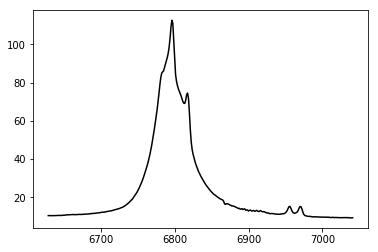

(0.9715391858725589, 0.621404344807894)


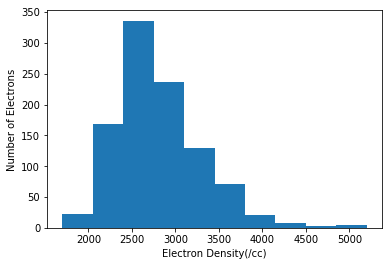

electron_density_core_indep_fit is 556.9651699425564 31.860226319861564
electron_density_wing_indep_fit 2730.8839905630257 488.19447575340666 2356.8936664016164 3263.737334470875
[ 3.09424359e+01  1.57502468e+01  3.56870727e+00  4.29994378e+00
  1.06699729e+04  1.00837322e+02  3.75961500e+01  2.25185367e+01
  2.61334645e-02  1.29194523e+00  1.02669487e+04  4.20735778e+02
  3.23682015e+01  1.07066524e+04  1.28538251e+03  8.04345311e+00
  1.17104404e+04  3.01777140e+03  0.00000000e+00  1.06650000e+04
  1.50000000e+03 -2.68221002e+00  2.81863988e+01]


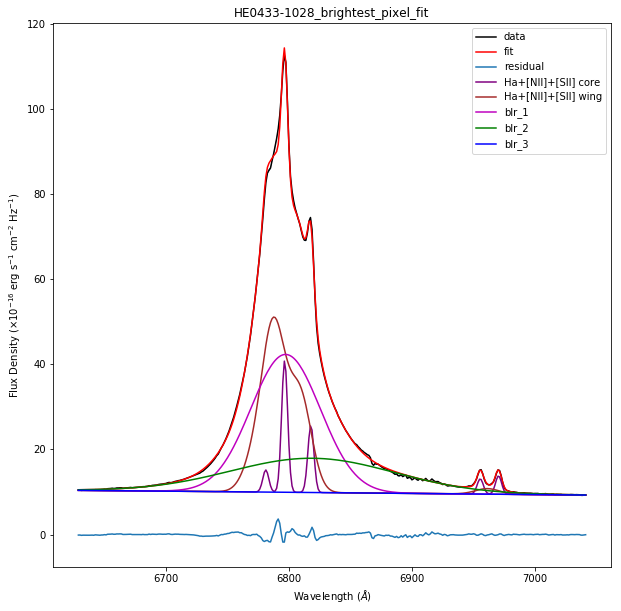

(0.8299427751946372, 0.02022799721770841)
electron_density_core_coupled is 974.7392030459416

NameError: global name 'Ne_core_err_coup' is not defined

In [40]:
z = {"HE0433-1028":0.035550} 
objs = z.keys()
p_init_complex = {'HE0433-1028':(20,15,5,5,10665,50,5,8,2,2,10365,300,5,10665,1000,5,10665,1500,0,10665,1500,-0.001,0.1)}
p_init_SII = {'HE0433-1028':(5,5,10665,50,2,2,10365,300,-0.001,0.1)}
#b =[(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf), (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 


HE0040-1105


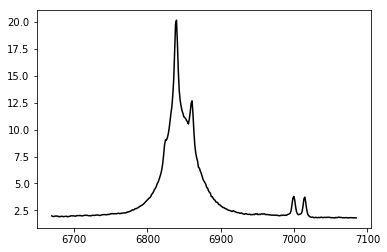

(1.058014355342035, 0.640453249854897)


ValueError: max must be larger than min in range parameter.

In [30]:
z = {"HE0040-1105":0.04196}

objs = z.keys()
#p_init_complex = {'HE0040-1105':(7.4,3.8,1.8,1.7,12507,80,0.9,0.9,0.1,0.2,12260,300,7.5,12507,800,2.5,12507,1500,0,12607,800,-0.25,3.64)}
p_init_complex = {'HE0040-1105':(7,3.5,1.7,1.6,12630,70,1,1,0.15,0.2,12550,100,7.5,12600,550,2.5,12600,1800,0,12588,500,-0.25,3.64)}
#p_init_complex = {'HE0040-1105':[6.96471997e+00,3.51393225e+00,1.70927660e+00,1.65218495e+00,1.26334223e+04,7.56285389e+01,3.51667979e+00,5.45669944e-01,1.72341427e-01,1.32737222e-01,1.25043857e+04,2.94961370e+02,4.12860073e+00,1.29768031e+04,6.74881841e+02,5.41235240e-01,1.33079048e+04,4.27880332e+03,4.28588952e+00,1.29247991e+04,1.27871842e+03,-1.77146104e-01,3.03267625e+00]}
p_init_SII = {'HE0040-1105':[1.87694146e+00,1.77111167e+00,1.25815027e+04,7.96934769e+01,1.28586194e-01,1.88260735e-01,1.22677663e+04,1.08495375e+02,-4.17013743e+00,3.11638372e+01]}

for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 

HE0253-1641


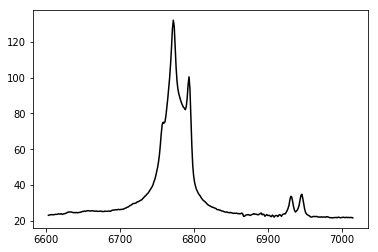

(1.187554201824752, 0.5454052352994487)
electron_density_core_indep_fit is 218.3168685963021
electron_density_wing_indep_fit 4944.522987966364
[ 2.96427683e+01  3.51116979e+01  9.56882636e+00  9.59015405e+00
  9.58708705e+03  8.82234948e+01  1.67308610e+01  1.34240177e+01
  2.14393310e+00  3.97567520e+00  9.41252858e+03  2.12215158e+02
  5.36106970e+01  9.70098061e+03  5.91231261e+02  1.43879328e+01
  9.40986648e+03  1.68311435e+03  0.00000000e+00  9.57600000e+03
  1.50000000e+03 -6.56601693e+00  6.80132081e+01]


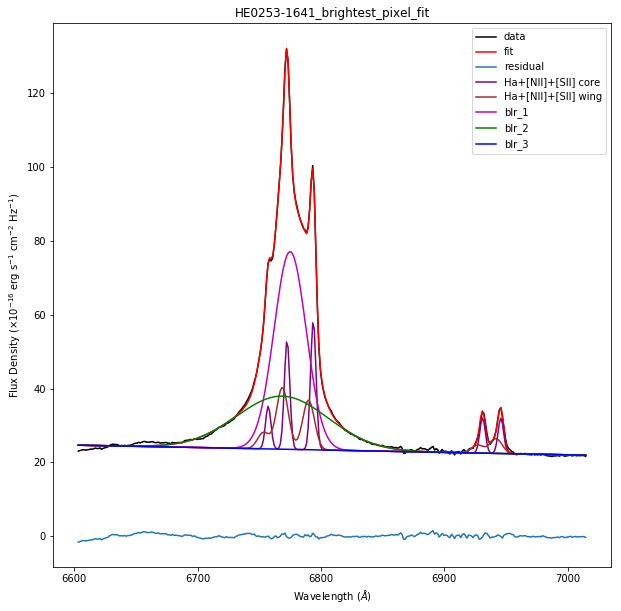

(0.9977760852430972, 0.5392626389147019)
electron_density_core_coupled is 501.83590264719095
electron_density_wing_coupled is 5240.608156687242
[ 3.14638468e+01  3.70979814e+01  9.58686928e+03  8.88259640e+01
  8.82252698e+00  8.50447439e+00  9.59064297e+03 -8.87150643e+01
  1.50710612e+01  1.13379733e+01  9.39235186e+03  1.84740069e+02
  2.50971655e+00  4.04387922e+00  9.47114404e+03  2.35452647e+02
  5.56265623e+01  9.70260695e+03  6.02811156e+02  1.39236541e+01
  9.39926458e+03  1.71060701e+03  0.00000000e+00  9.57600000e+03
  1.50000000e+03 -6.60891304e+00  6.82708997e+01]


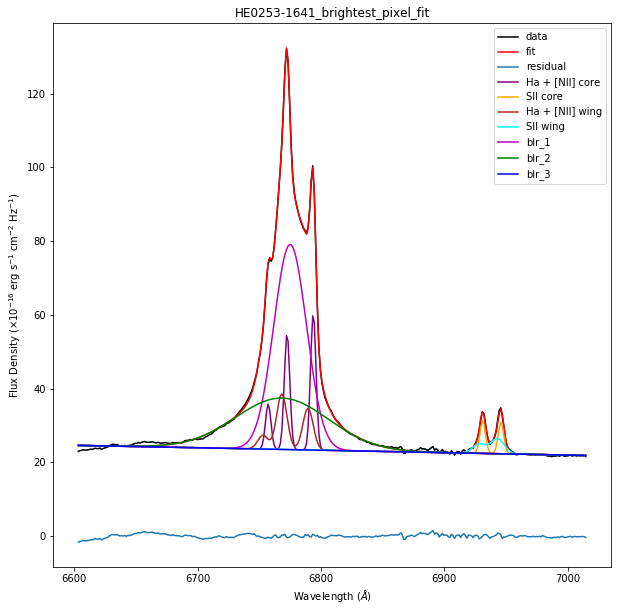

(1.0373982659983776, 0.6206210468869552)
electron_density_core is 428.23111098065056
electron_density_wing is 2739.146864432323


In [8]:
z = {"HE0253-1641":0.031588} # 2 broad components
objs = z.keys()
p_init_complex = {'HE0253-1641':(34,40,9,11,9476,90,20,20,4,5,9400,100,5,9476,500,5,9576,1500,0,9576,1500,-0.001,0.1)}

p_init_SII = {'HE0253-1641':[5,5,9476,50,2,2,9276,100,-0.001,0.1]}



for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 

HE0224-2834


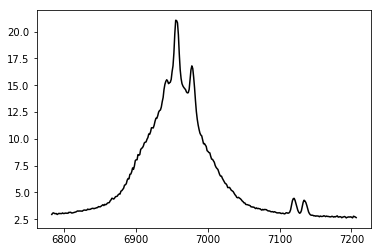

(1.193981973868053, 0.6037195046461169)
electron_density_core_indep_fit is 211.18086157626112
electron_density_wing_indep_fit 3072.3724431682713
[ 7.66023925e+00  4.54103049e+00  1.46346263e+00  1.34867575e+00
  1.80100232e+04  1.42756673e+02  1.51452106e+00  1.43574018e+00
 -4.32394148e-02  2.49706569e-03  1.75590068e+04  1.96633524e+02
  1.30081535e+00  1.85284137e+04  3.65489077e+03  9.48079419e+00
  1.78837928e+04  1.83217532e+03  0.00000000e+00  1.79400000e+04
  8.00000000e+02 -6.22875239e-01  7.16445289e+00]


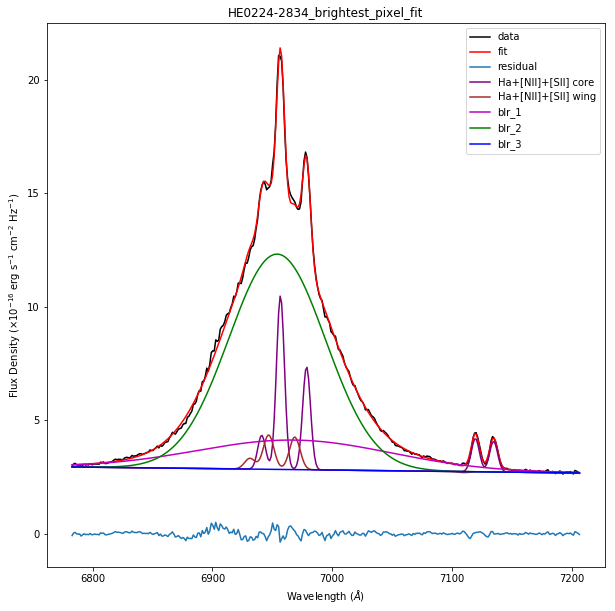

(1.0851108031588916, -17.31609022313204)
electron_density_core_coupled is 350.55307613891756
electron_density_wing_coupled is nan
[ 7.73464616e+00  4.66433887e+00  1.79970055e+04  1.55926920e+02
  1.38842632e+00  1.15867721e+00  1.80430163e+04  1.30493465e+02
  1.37282949e+00  1.49219726e+00  1.75056209e+04  1.47701968e+02
  2.56013290e-01  4.43751497e-01  1.79306424e+04  5.54944116e+01
  1.20158205e+00  1.86245250e+04  3.75382276e+03  9.54003074e+00
  1.78792062e+04  1.84535846e+03  0.00000000e+00  1.79400000e+04
  8.00000000e+02 -6.46451477e-01  7.32777818e+00]


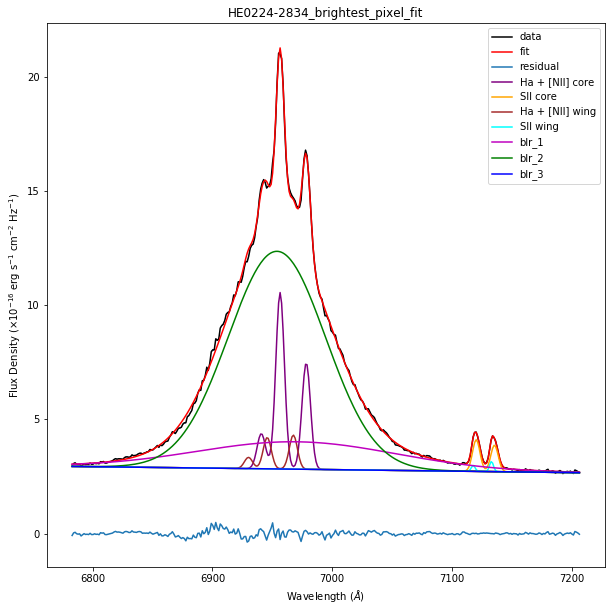

(1.1982856947972649, 0.5769294121564119)
electron_density_core is 206.44960463914194
electron_density_wing is 3744.675972900919


In [9]:
z = {"HE0224-2834":0.059800}

objs = z.keys()
p_init_complex = {'HE0224-2834':(5,2,1.5,1.2,17990,130,2.0,0.9,0.14,0.2,17940,180,5,17990,800,0,17990,800,0,17940,800,-0.25,3.64)}
#p_init_complex = {'HE0040-1105':(7,4,1.8,1.7,12507,80,1,1,0.1,0.2,12307,3040,7.5,12507,800,2.5,12507,1500,0,0,0,-0.25,3.64)}
p_init_SII = {'HE0224-2834':[1.28347008e+00,1.08543217e+00,1.80556524e+04,1.23064387e+02,3.99785108e-01,5.61026655e-01,1.79296652e+04,6.42081964e+01,-6.73939395e+00,5.09879797e+01]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init_SII[obj],p_init_complex[obj]) 